### Welcome to the exercise about observational studies! This exercise will be hands on, and you will be able to practise the skills you developed so far!

## Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 6 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to deepen your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
%matplotlib inline

data_folder = './data/'
df = pd.read_csv(data_folder + 'lalonde.csv')

In [2]:
df.sample(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
506,PSID322,0,23,12,0,0,0,0,3893.063,0.000,16324.450
293,PSID109,0,21,15,0,0,1,0,6951.479,3879.629,0.000
363,PSID179,0,18,11,1,0,0,1,2068.986,1623.823,20243.380
220,PSID36,0,27,12,0,0,1,0,9788.497,7496.081,14038.400
526,PSID342,0,20,10,0,0,0,1,1412.631,0.000,6290.682
395,PSID211,0,20,12,0,0,0,0,0.000,1147.597,15554.550
377,PSID193,0,18,8,0,0,0,1,5023.560,1391.081,6756.166
517,PSID333,0,19,6,1,0,0,1,1955.348,0.000,14998.920
591,PSID407,0,23,12,0,0,0,0,0.000,0.000,3902.676
519,PSID335,0,19,12,1,0,0,0,1681.051,0.000,0.000


## 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lecture 4 ("Descibing data") and 3 ("Visualizing data").

What might a naive "researcher" conclude from this superficial analysis?

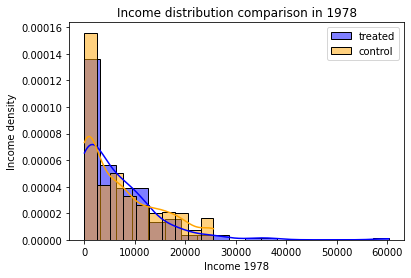

In [13]:
''' your code and explanations '''
treated_df = df[df["treat"]==1]
control_df = df[df["treat"]==0]

ax = sns.histplot(treated_df['re78'], kde=True, stat='density', color='blue', label='treated',)
ax = sns.histplot(control_df['re78'], kde=True, stat='density', color='orange', label='control')
ax.set(title='Income distribution comparison in 1978',xlabel='Income 1978', ylabel='Income density')
plt.legend()
plt.show()

In [19]:
print("\nTreated:\n", treated_df['re78'].describe())
print("\nControl:\n", control_df['re78'].describe())

'''
Observations:
- It seems treated group actually has slightly less avg income than control group, which is sad :'(
- So, training program backfired & instead of improving income, it made it worse, really?

''';


Treated:
 count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

Control:
 count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64


## 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

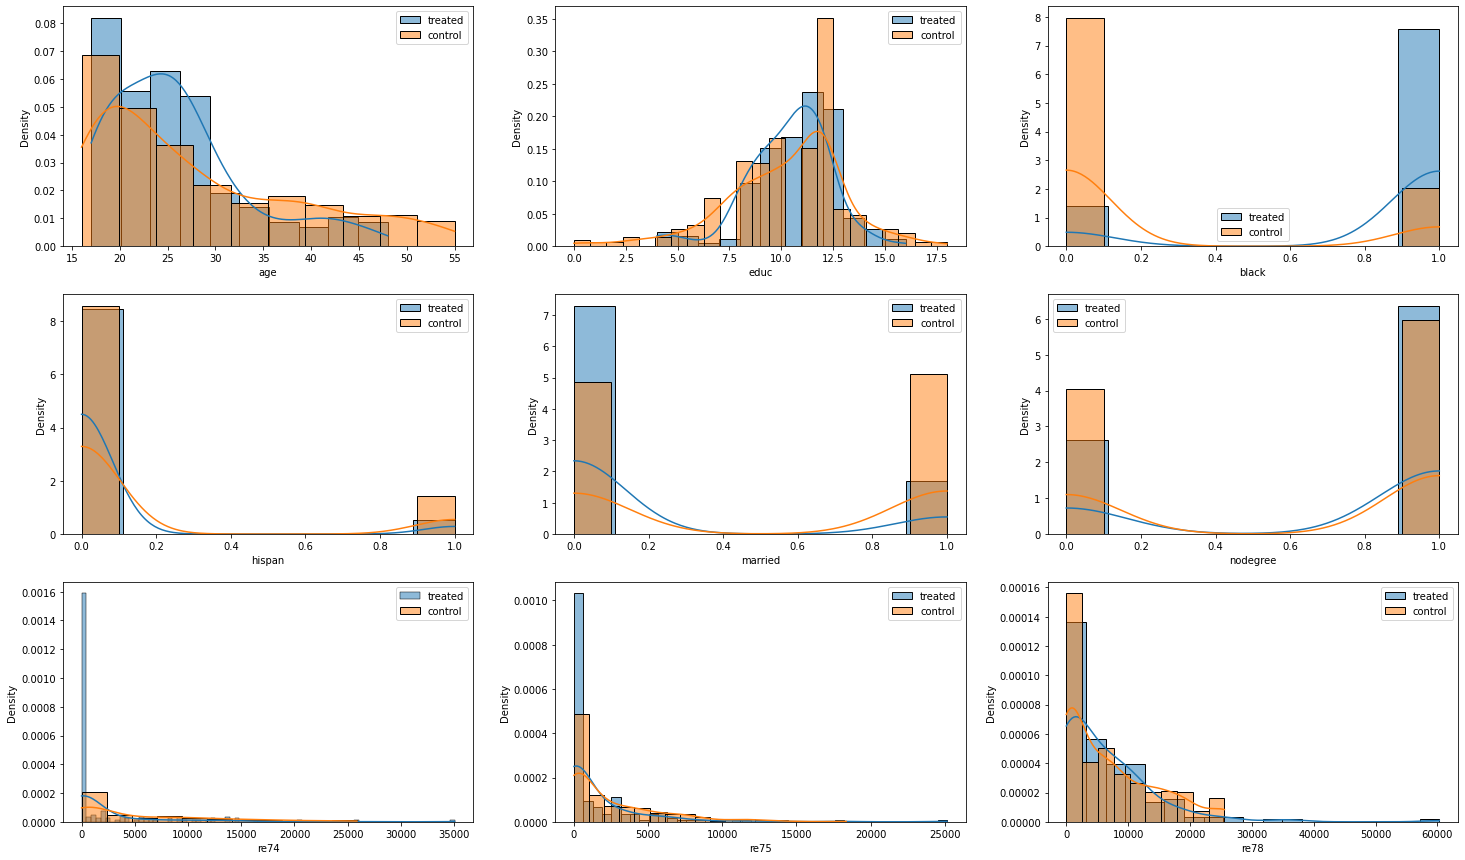

In [34]:
''' your code and explanations '''
columns = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75', 're78']

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(25,15)) 

for ax, col in zip(axs.flat, columns):
    sns.histplot(treated_df[col], kde=True, stat='density', label=f'treated', ax=ax)
    sns.histplot(control_df[col], kde=True, stat='density', label=f'control', ax=ax)
    ax.legend()  # Add legend to each subplot
    
plt.legend()
plt.show()

'''
Observed differences b/w Treated & Control groups:

- Age: 
    - treated group has more frac of young people than control group

- Black:
    - treated group has more frac of black people.

- re75:
    - income in the previous year (before training program)
    - treated group has a lot more people who were unemployed (0 income) in previous year (1975)

- married:
    - trated group has a lot more unmarried people
    
''';

## 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `statsmodels` to fit the logistic regression model and fit it on entire dataset to obtain propensity scores.

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).)

In [42]:
''' your code and explanations '''
import statsmodels.formula.api as smf

# logistic regression: binary classifier --> given input feature, it will tell whether treated (0 or 1) with probability
# features: [age, educ, black....]
# label: treated (0,1)

X = df.copy()

# let's standardize the continuous features (optional, but recommended)
X['age'] = (df['age'] - df['age'].mean())/df['age'].std()
X['educ'] = (df['educ'] - df['educ'].mean())/df['educ'].std()
X['re74'] = (df['re74'] - df['re74'].mean())/df['re74'].std()
X['re75'] = (df['re75'] - df['re75'].mean())/df['re75'].std()

# intialize logistic regression model obj
model = smf.logit(formula='treat ~  age + educ + C(black) + C(hispan)  + C(married) + C(nodegree) +re74 + re75', data=X)

# train model
result = model.fit()
 
print(result.summary(),"\n\n") # summary() is func of result obj returned by model.fit(), not of pandas!

# predict() generates predicted prob of 'treat' being 1 for each observation in dataset i-e propensity scores
X['Propensity_score'] = result.predict() # for each row i-e feature vector, it will give prob whether treat is '1' -> propenstiy score
X


Optimization terminated successfully.
         Current function value: 0.397267
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Mon, 23 Dec 2024   Pseudo R-squ.:                  0.3508
Time:                        08:20:35   Log-Likelihood:                -243.92
converged:                       True   LL-Null:                       -375.75
Covariance Type:            nonrobust   LLR p-value:                 2.194e-52
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -2.8509      0.350     -8.147      0.000      -3.537      -2.165
C(black)[T.

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,Propensity_score
0,NSW1,1,0.975268,0.278227,1,0,1,1,-0.703546,-0.662971,9930.0460,0.638770
1,NSW2,1,-0.542768,-0.482714,0,1,0,1,-0.703546,-0.662971,3595.8940,0.224634
2,NSW3,1,0.266851,0.658697,1,0,0,0,-0.703546,-0.662971,24909.4500,0.678244
3,NSW4,1,-0.036756,0.278227,1,0,0,1,-0.703546,-0.662971,7506.1460,0.776324
4,NSW5,1,0.570459,-0.863185,1,0,0,1,-0.703546,-0.662971,289.7899,0.701639
...,...,...,...,...,...,...,...,...,...,...,...,...
609,PSID425,0,-0.947578,0.278227,0,0,0,1,-0.703546,-0.662971,10150.5000,0.123144
610,PSID426,0,-0.340363,-3.526478,0,1,1,1,-0.703546,-0.662971,19464.6100,0.034560
611,PSID427,0,-0.643970,2.941520,0,0,0,0,-0.703546,-0.662971,0.0000,0.183351
612,PSID428,0,0.469256,-2.004596,1,0,1,1,-0.703546,-0.662971,187.6713,0.383032


## 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

This is how **networkx** library can help you do this. Each possible pair of (treated_person, control_person) is characterized by a similarity. This is how we can initialize a graph, and add an edge for one possible pair. We then need to add an edge for each possible pair.
    - G = nx.Graph()
    - G.add_weighted_edges_from([(control_person, treated_person, similarity)])
Optimal matching is then found with:
    - matching = nx.max_weight_matching(G)

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

In [43]:
''' your code and explanations ''';
def get_similarity(propensity_score1, propensity_score2):
    # Calculate similarity between given propensity scores via abs difference
    return 1 - np.abs(propensity_score1-propensity_score2)

# Separate the treatment and control groups
treatment_df = df[df['treat'] == 1]
control_df = df[df['treat'] == 0]

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances/feature vectors/rows
for control_idx, control_row in control_df.iterrows():
    for treatment_idx, treatment_row in treatment_df.iterrows():

        # Calculate the similarity 
        similarity = get_similarity(control_row['Propensity_score'], treatment_row['Propensity_score'])

        # Add an edge between the two instances weighted by the similarity between them
        G.add_weighted_edges_from([(control_idx, treatment_idx, similarity)]) # use idx as node's id in graph

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)
matching # matching is a set of tuples, where each represents a matched pair of nodes (instances) in the graph. matching={ (node-0,node-404), (node-1,node-545), ... } --> all tuples are unique cuz it's a set!

'''
- 'matching' --> contains edges as tuple e.g, (node-1, node-653)
    - NOTE: 'matching' does NOT contains all the nodes, only nodes that could form a pair with another node with similar propensity score
    - So, if we only consider nodes from 'matching' in our dataset, dataset will be balanced (i-e all covariates like income, married, etc will have similar distribution in dataset)
        - it's due to "balancing property of propensity score" (slide#36, Lec06)
        - dataset will now have equal distribution of observed covariates (black race, married, age, income, etc)

''';

{(0, 404),
 (1, 545),
 (2, 601),
 (5, 593),
 (6, 550),
 (7, 302),
 (9, 528),
 (11, 517),
 (12, 484),
 (14, 368),
 (17, 557),
 (18, 225),
 (19, 569),
 (21, 261),
 (22, 589),
 (23, 451),
 (25, 275),
 (27, 513),
 (31, 563),
 (32, 477),
 (34, 449),
 (35, 536),
 (37, 537),
 (38, 232),
 (39, 519),
 (40, 393),
 (41, 459),
 (43, 435),
 (47, 452),
 (48, 535),
 (51, 588),
 (54, 354),
 (56, 418),
 (58, 367),
 (59, 458),
 (61, 281),
 (64, 425),
 (65, 464),
 (67, 298),
 (68, 466),
 (69, 324),
 (70, 590),
 (72, 479),
 (73, 408),
 (76, 542),
 (77, 603),
 (81, 515),
 (82, 526),
 (84, 529),
 (86, 611),
 (87, 575),
 (88, 322),
 (89, 192),
 (91, 273),
 (95, 360),
 (96, 437),
 (97, 465),
 (99, 383),
 (100, 243),
 (104, 596),
 (105, 280),
 (109, 424),
 (110, 348),
 (111, 448),
 (112, 263),
 (114, 370),
 (115, 574),
 (116, 376),
 (117, 594),
 (119, 475),
 (120, 600),
 (123, 217),
 (124, 340),
 (125, 422),
 (127, 546),
 (128, 608),
 (129, 282),
 (130, 518),
 (132, 386),
 (133, 250),
 (136, 293),
 (137, 540),

In [ ]:
'''
- [i[0] for i in list(matching)] --> extracts 1st elements (i[0]) from each matched tuple i-e edge
- [i[1] for i in list(matching)] --> extracts 2nd elements (i[1]) from each matched tuple i-e edge

- Now, let's just add all nodes from each match tuple i-e edge in our dataset
    - you can do it in any way you like, doesn't matter how, ordering doesn't matter whatsoever
    - E.g, matched = [nodes who are 1st elem in matched tuple] + [nodes who are 2nd elem in matched tuple]

- We know: node id = idx of df
- So, to get all correpsonding feature vector (person), simply do --> df.iloc[matched]
'''

print([i[0] for i in list(matching)][:10])
print([i[1] for i in list(matching)][:10])

matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)] # all nodes (idx of df) in matched edge tuple in a single list --> list of idx
print("matched idx:", matched[:10])

'''
df.iloc[matched]:
    - iloc selects rows in df based on indices in 'matched' list.
    - Syntax: df.iloc[<idx or [list of indices]>]
'''
balanced_df = df.iloc[matched]

# it now contains only those nodes that formed a pair with another node with similar propensity score, not ALL nodes as in original df
balanced_df

[5, 584, 58, 401, 68, 162, 35, 180, 97, 373]
[593, 102, 367, 157, 466, 604, 536, 201, 465, 131]
matched idx: [5, 584, 58, 401, 68, 162, 35, 180, 97, 373]


,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,Propensity_score
5,NSW6,1,22,9,1,0,0,1,0.000,0.0000,4056.4940,0.699070
584,PSID400,0,37,8,1,0,0,1,0.000,0.0000,648.7220,0.714680
58,NSW59,1,42,14,1,0,1,0,0.000,0.0000,13167.5200,0.604808
401,PSID217,0,32,16,1,0,0,0,17135.750,1031.2260,0.0000,0.561601
68,NSW69,1,45,5,1,0,1,1,0.000,0.0000,8546.7150,0.432515
...,...,...,...,...,...,...,...,...,...,...,...,...
225,PSID41,0,22,12,1,0,1,0,9729.719,7372.5480,2231.3670,0.373566
293,PSID109,0,21,15,0,0,1,0,6951.479,3879.6290,0.0000,0.043048
408,PSID224,0,39,11,0,0,0,1,0.000,930.9677,0.0000,0.170525
612,PSID428,0,32,5,1,0,1,1,0.000,0.0000,187.6713,0.383032


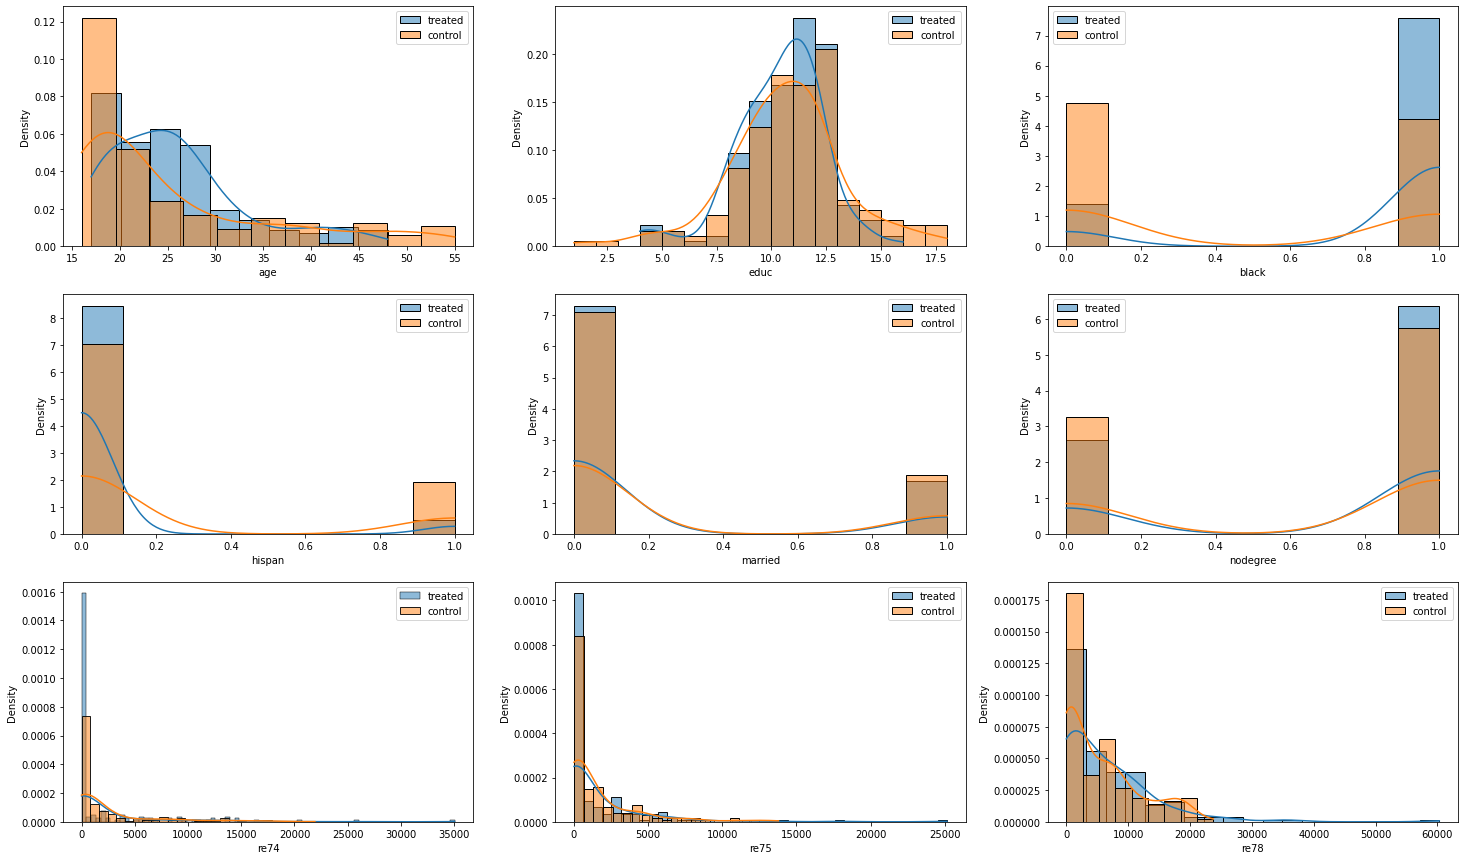

In [55]:
# Check if balanced_df is actually balanced

treated_df = balanced_df[balanced_df["treat"]==1]
control_df = balanced_df[balanced_df["treat"]==0]

columns = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75', 're78']
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(25,15)) 

for ax, col in zip(axs.flat, columns):
    sns.histplot(treated_df[col], kde=True, stat='density', label=f'treated', ax=ax)
    sns.histplot(control_df[col], kde=True, stat='density', label=f'control', ax=ax)
    ax.legend()  # Add legend to each subplot
    
plt.legend()
plt.show()

'''
Observation:
    - Better than before, but still some skewed in 'black'
        - Though difference is reduced, but still a bit more black in treated group
'''

## 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


In [58]:
''' your code and explanations '''
'''
- To fix skew in black, we'll do propesntiy score matching thing again with graph
- But now, we'll only create an edge i-e match only if both nodes have same race so that in the end the distribution of race is balanced in the dataset
    - E.g, this way you don't match a hispan with a black, and again a hispan with a hispan --> 3 hispans, 1 black in dataset
'''

treatment_df = df[df['treat'] == 1]
control_df = df[df['treat'] == 0]

G = nx.Graph()

for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():

        # Adds an edge only if the individuals have the same race (only 2 possible: hispan, black)
        if (control_row['black'] == treatment_row['black']) and (control_row['hispan'] == treatment_row['hispan']):
            similarity = get_similarity(control_row['Propensity_score'], treatment_row['Propensity_score'])
            G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

matching = nx.max_weight_matching(G)
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
balanced_final_df = df.iloc[matched]

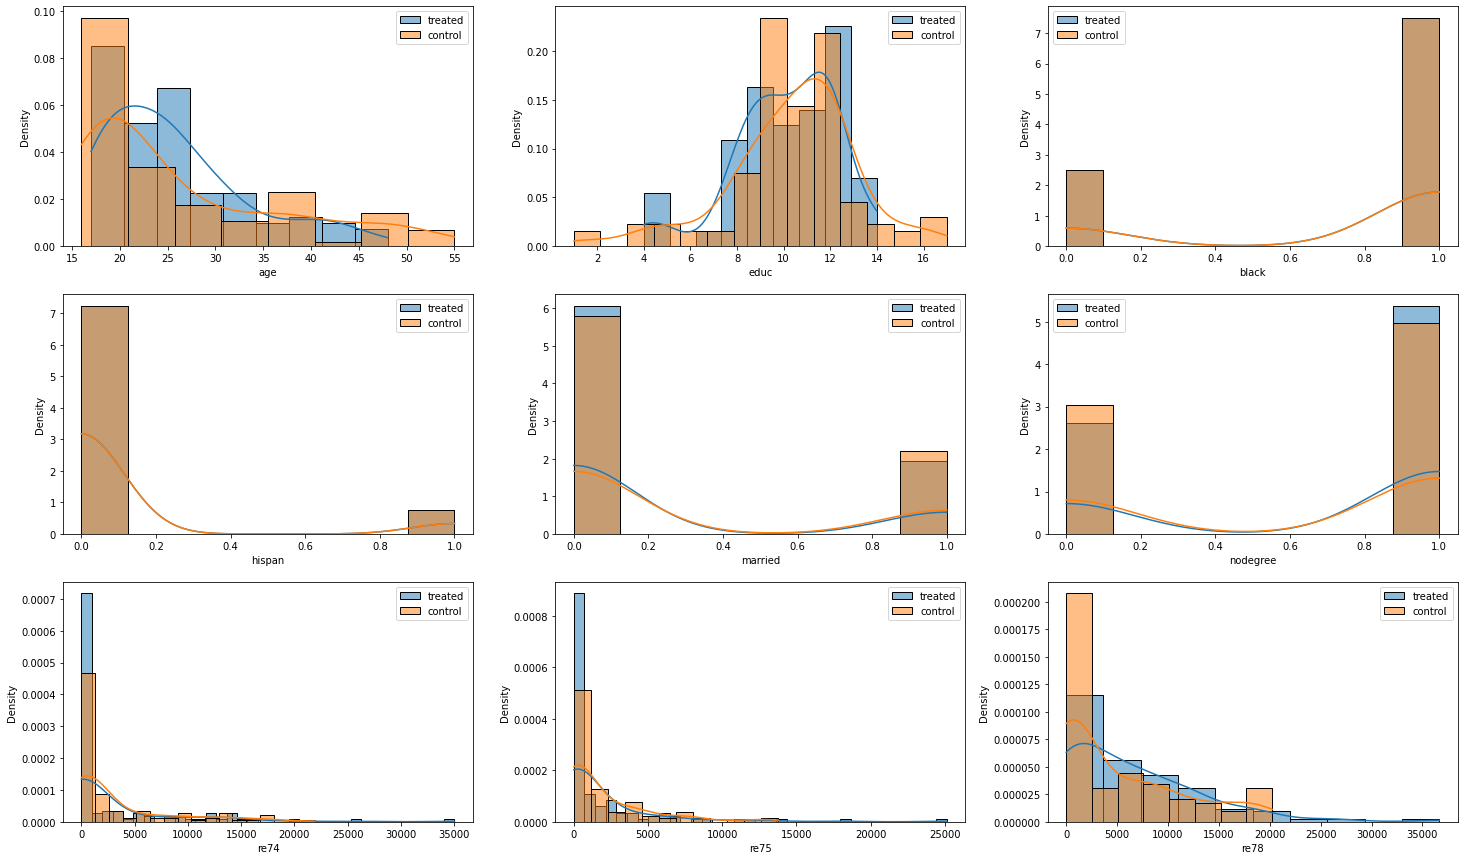

"\nObservation:\n    - Better than before, but still some skewed in 'black'\n        - Though difference is reduced, but still a bit more black in treated group\n"

In [ ]:
# Check if balanced_df is actually balanced

treated_df = balanced_final_df[balanced_final_df["treat"]==1]
control_df = balanced_final_df[balanced_final_df["treat"]==0]

columns = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75', 're78']
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(25,15)) 

for ax, col in zip(axs.flat, columns):
    sns.histplot(treated_df[col], kde=True, stat='density', label=f'treated', ax=ax)
    sns.histplot(control_df[col], kde=True, stat='density', label=f'control', ax=ax)
    ax.legend()  # Add legend to each subplot
    
plt.legend()
plt.show()

'''
Observation:
    - Now, 'black' is completelty balanced. Treated & control have same distribution of black
'''

## 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

In [64]:
''' your code and explanations ''';
# created from final balanced df (obtained after balancing 'black')
print("\ntreated re78:\n",treated_df.re78.describe())
print("\ncontrol re78:\n",control_df.re78.describe())

'''
Observation:
    - Now, we see that program has indeed works because avg income (re78) for treated is much higher than control group: 6375.73 vs 5095.45
'''


treated re78:
 count      116.000000
mean      6375.738003
std       6670.986821
min          0.000000
25%        758.102600
50%       4648.736000
75%      10160.440000
max      36646.950000
Name: re78, dtype: float64

control re78:
 count      116.000000
mean      5095.456025
std       6047.014862
min          0.000000
25%          0.000000
50%       2256.488500
75%       8942.092750
max      20243.380000
Name: re78, dtype: float64


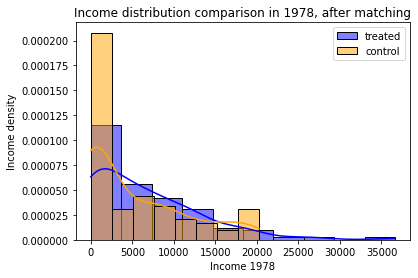

In [65]:
# plotting to see difference visually
ax = sns.histplot(treated_df['re78'], kde=True, stat='density', color='blue', label='treated');
ax = sns.histplot(control_df['re78'], kde=True, stat='density', color='orange', label='control')
ax.set(title='Income distribution comparison in 1978, after matching',xlabel='Income 1978', ylabel='Income density')
plt.legend()
plt.show()

'''
Conclusion: 
    - After the propensity score matching, we were able to see thath the results drastically change & support the positive effect of the training program.
''';